## IBM Coursera Capstone Project

This is the capstone project for the IBM Coursera Professional Certificate

In [152]:
import pandas as pd
import numpy as np
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [153]:
import requests
from bs4 import BeautifulSoup

Request the html from the wikipedia website and read it into a BeatifulSoup object

In [154]:
result = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

In [155]:
bs = BeautifulSoup(result.content,"lxml")

Loop through the table and append each of the rows to a string  
Put it into a dataframe and filter out the postal codes that dont have a Borough assigned

In [156]:
import re
bs_table = bs.find("tbody")

data = [] 
for row in bs_table.find_all("tr"):
    data.append([r.text.strip() for r in row.find_all("td")])
                 
d = pd.DataFrame(data[1:],columns=["postal_code","borough","neighborhood"])
d = d.loc[d.borough != "Not assigned"]
d

,postal_code,borough,neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


If a postal code belongs to multiple neighborhoods then append the neighborhoods with a comma. We are assuming that each postal code only belongs to 1 borough here. 

In [157]:
d = d.groupby(["postal_code","borough"])["neighborhood"].apply(lambda x: ",".join(x)).reset_index()

#Confirming that the neighborhoods were joined succesffuly
d.loc[d.postal_code == "M5A"]

,postal_code,borough,neighborhood
53,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In case there are blank neighborhoods, set them to the borough. It doesnt appear that any of the data contains this instance however this was still done for future iterations.

In [158]:
d["neighborhood"] = d.apply(lambda x: x.borough if x.neighborhood == "" else x.neighborhood, axis = 1)

In [159]:
d.shape

(103, 3)

## Get Longitude and Latitude for each postal code

In [160]:
geo = pd.read_csv("Geospatial_Coordinates.csv").rename(columns= {"Postal Code":"postal_code"})
geo.head()

,postal_code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [161]:
data = pd.merge(left=d,right=geo,on="postal_code")

## Get Data to cluster the neighborhoods

In [162]:
toronto_data = data.loc[data.borough.str.contains("Toronto")]

In [1]:
CLIENT_ID = 'D2CKJKGH5FB0CCTRQNUHPTYJTZNJLZCVKPUDDO5UACTUF3NK'
CLIENT_SECRET = 'QD14BR5AFKUH1Q5A3F303ZRIE1I0KXIZLVTVJA305V1MNFAH'
VERSION = '20200601'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [169]:
toronto_venues = getNearbyVenues(names=toronto_data['neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

### Counting the number of each venues per neighborhood them clustering based on the counts

In [284]:
 to_neighborhood = toronto_venues.groupby(["Neighborhood","Venue Category"])["Venue"] \
.count().to_frame().reset_index().pivot(index="Neighborhood",columns="Venue Category").fillna(0)


to_neighborhood.head()

Venue          \
Venue Category                                     Afghan Restaurant Airport   
Neighborhood                                                                   
Berczy Park                                                      0.0     0.0   
Brockton, Parkdale Village, Exhibition Place                     0.0     0.0   
Business reply mail Processing Centre, South Ce...               0.0     0.0   
CN Tower, King and Spadina, Railway Lands, Harb...               0.0     1.0   
Central Bay Street                                               0.0     0.0   

                                                                       \
Venue Category                                     Airport Food Court   
Neighborhood                                                            
Berczy Park                                                       0.0   
Brockton, Parkdale Village, Exhibition Place                      0.0   
Business reply mail Processing Centre, South Ce...                0.0   
CN Tower, King and Spadina, Railway Lands, Harb...                1.0   
Central Bay Street                                                0.0   

                                                                 \
Venue Category                                     Airport Gate   
Neighborhood                                                      
Berczy Park                                                 0.0   
Brockton, Parkdale Village, Exhibition Place                0.0   
Business reply mail Processing Centre, South Ce...          0.0   
CN Tower, King and Spadina, Railway Lands, Harb...          1.0   
Central Bay Street                                          0.0   

                                                                   \
Venue Category                                     Airport Lounge   
Neighborhood                                                        
Berczy Park                                                   0.0   
Brockton, Parkdale Village, Exhibition Place                  0.0   
Business reply mail Processing Centre, South Ce...            0.0   
CN Tower, King and Spadina, Railway Lands, Harb...            1.0   
Central Bay Street                                            0.0   

                                                                    \
Venue Category                                     Airport Service   
Neighborhood                                                         
Berczy Park                                                    0.0   
Brockton, Parkdale Village, Exhibition Place                   0.0   
Business reply mail Processing Centre, South Ce...             0.0   
CN Tower, King and Spadina, Railway Lands, Harb...             2.0   
Central Bay Street                                             0.0   

                                                                     \
Venue Category                                     Airport Terminal   
Neighborhood                                                          
Berczy Park                                                     0.0   
Brockton, Parkdale Village, Exhibition Place                    0.0   
Business reply mail Processing Centre, South Ce...              0.0   
CN Tower, King and Spadina, Railway Lands, Harb...              1.0   
Central Bay Street                                              0.0   

                                                                        \
Venue Category                                     American Restaurant   
Neighborhood                                                             
Berczy Park                                                        0.0   
Brockton, Parkdale Village, Exhibition Place                       0.0   
Business reply mail Processing Centre, South Ce...                 0.0   
CN Tower, King and Spadina, Railway Lands, Harb...                 0.0   
Central Bay Street                                                 0.0   

                        

In [285]:
from sklearn.cluster import KMeans


num_clusters = range(2,10)
scores = []
for n in num_clusters:
    kmeans= KMeans(n_clusters=n)
    clusters = kmeans.fit(to_neighborhood).labels_
    scores.append(silhouette_score(to_neighborhood,clusters))

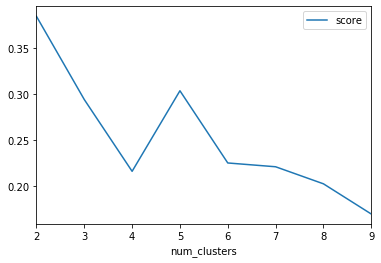

In [286]:
%matplotlib inline
from sklearn.metrics import silhouette_score
cluster_score = pd.DataFrame({"num_clusters":num_clusters,"score":scores})
cluster_score.plot(x="num_clusters",y="score")


While 2 gives us the highest score it doesnt provide much value 5 provides decently amount of value considering it has a similar score to 3

## Mapping clusters

In [287]:
kclusters = 5
kmeans= KMeans(n_clusters=kclusters)
clusters = kmeans.fit(to_neighborhood).labels_

to_neighborhood.columns = to_neighborhood.columns.droplevel()
to_neighborhood["cluster"] = clusters

In [288]:
to_neighborhood= to_neighborhood.drop(columns=["Neighborhood"]).reset_index()

In [289]:
cluster_locations = pd.merge(left=toronto_data,right=to_neighborhood,left_on="neighborhood",right_on="Neighborhood")

In [291]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map 43.657952	-79.387383
map_clusters = folium.Map(location=[43.657952, -79.387383], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_locations['Latitude'], cluster_locations['Longitude'], cluster_locations['Neighborhood'], cluster_locations['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

These clusters are likely clustering based on the density of venues within a given neighborhood (Since it was based on count and not frequency as it was in the other notebook). This makes sense as there are clusters close to downdown Toronto which makes sense as venues are likely at a higher density there.

<img src="toronto_neighborhood_clusters.png">